In [ ]:

####################################################################################################
# Load model for testing
####################################################################################################

from keras.models import load_model

test_model_name = '/home/janciovec/Desktop/Model/SN_512_256_x00_w-50-0.74-0.70-1.01-0.63.hdf5'
# 77.8 on maxprob
model = load_model(test_model_name)
print model.summary()

####################################################################################################
# Predict on Test set
####################################################################################################

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import sys
# import tifffile as tiff
import os
import numpy as np
# from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import glob
from keras.preprocessing import image
from keras.utils import to_categorical

####################################################################################################

RGB_means = [
    180.375933345 , 148.276127037 , 174.592562423
]
# AWS: 180.375933345 , 148.276127037 , 174.592562423
# HPC: 180.7795009644826 , 148.3537065177495 , 174.59451631969864

# Image size (assume same for all images)
img_width =  2048
img_height = 1536
pix_scale = 0.42 # micrometers

target_size = (256, 256)

# Create patches
patch_width = 512                # DON'T CHANGE
patch_height = patch_width
patch_stride = 256 # 512 ? try
N_patches_x = (((img_width - patch_width) / patch_stride) + 1)
N_patches_y = (((img_height - patch_height) / patch_stride) + 1)
N_patches_per_img = N_patches_x * N_patches_y
print "Number of patches per image: ", N_patches_per_img, " = ", N_patches_x, " x ", N_patches_y

true_labels = np.concatenate( (np.repeat(0, 5), np.repeat(1, 5), np.repeat(2, 5), np.repeat(3, 5),
                               np.repeat(0, 4), np.repeat(1, 4), np.repeat(2, 4), np.repeat(3, 4)))
N_test_imgs = len(true_labels)

print "#test images =", N_test_imgs
print "True labels = ", true_labels

path_prefix = './../Dataset/ICIAR2018_BACH_Challenge/Test_org_SN/'

classes = ['Normal', 'Benign', 'InSitu', 'Invasive'] # the same order as labels 0,1,2,3

PREDICTIONS = np.zeros( (N_test_imgs, N_patches_per_img, len(classes)) )

def substract_mean(patch):
    # RGB
    patch[:,:,0] -= RGB_means[0]
    patch[:,:,1] -= RGB_means[1]
    patch[:,:,2] -= RGB_means[2]
    return patch

# Iterate over test images
for img_name in glob.glob(path_prefix + '*.tif'): # can be any order, predictions are saved using indexing
#     print img_name
    img = image.img_to_array(image.load_img(img_name)) # RGB channel order
    imgID = int((img_name.split('/')[-1]).split('.')[-2])
#     print imgID
    true_img_label = true_labels[imgID] # true label for this image is: true_labels[imgID]

    # Split into patches
    for i in range(N_patches_x):
        for j in range(N_patches_y):
            patch = img[j*patch_stride:j*patch_stride + patch_height, i*patch_stride:i*patch_stride + patch_width, :]
            patch_resized = cv2.resize(patch, target_size, interpolation=cv2.INTER_NEAREST)  # resize patch to target_size
            ms_patch = substract_mean(patch_resized)   # mean substraction
            rs_ms_patch = np.reshape(ms_patch, [1,target_size[0],target_size[1],3]) # reshape

            PREDICTIONS[imgID, i*N_patches_y + j] = model.predict_proba(rs_ms_patch)[0]


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        36928     
__________

Normal 0
Normal
Normal


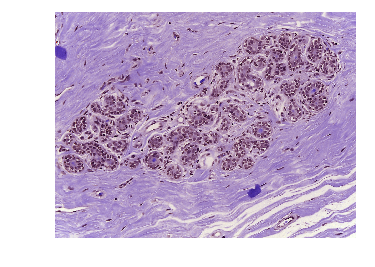

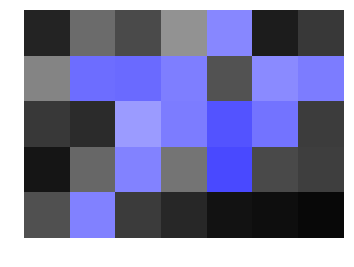

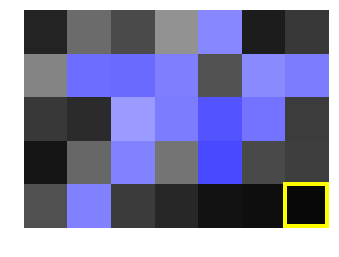

Normal 1
Normal
Normal


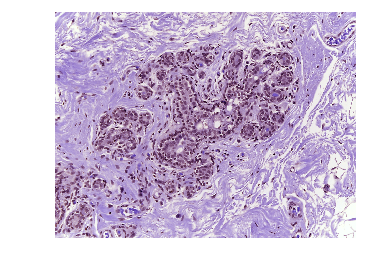

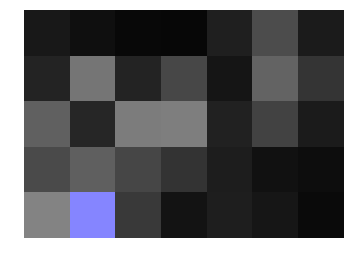

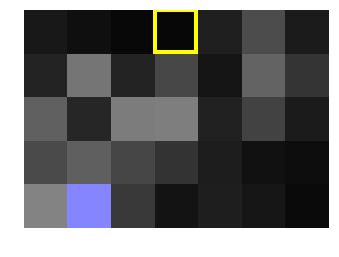

Normal 2
Normal
Normal


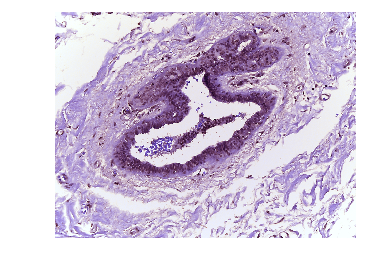

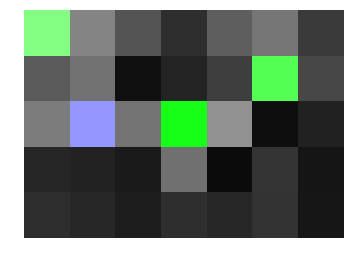

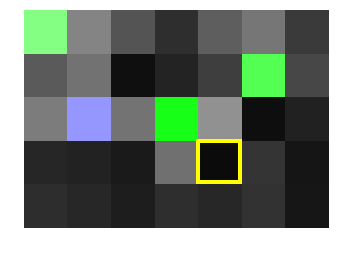

Normal 3
Normal
Normal


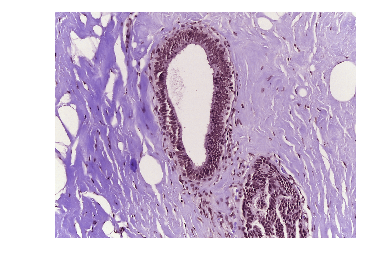

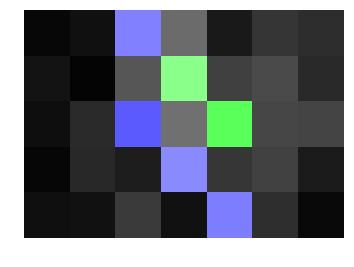

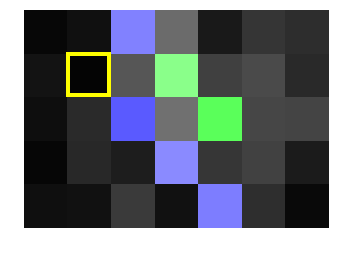

Benign 5
Benign
Benign


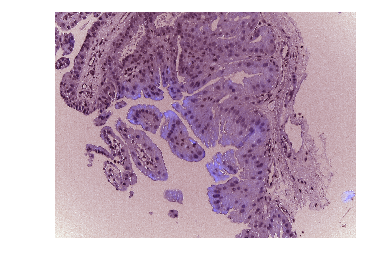

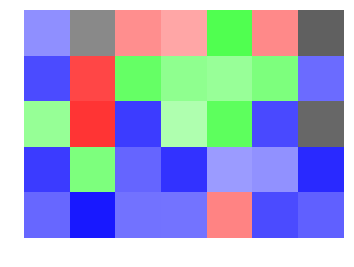

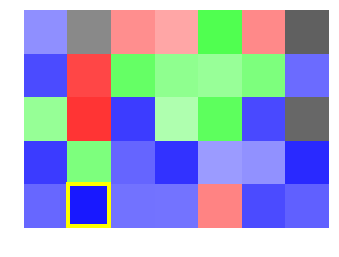

Benign 6
Benign
Benign


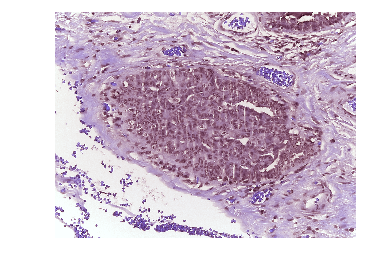

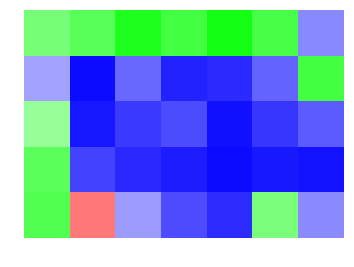

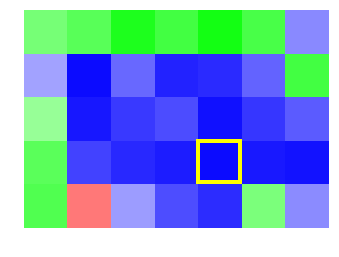

Benign 7
Benign
Benign


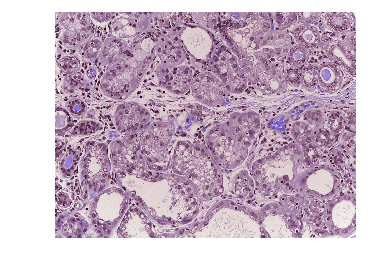

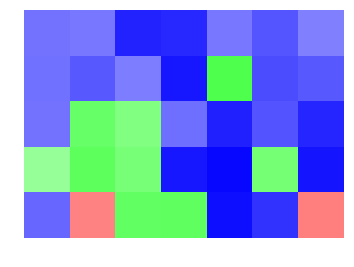

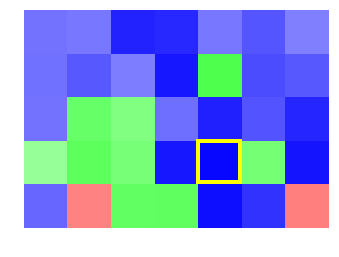

Benign 8
Benign
Benign


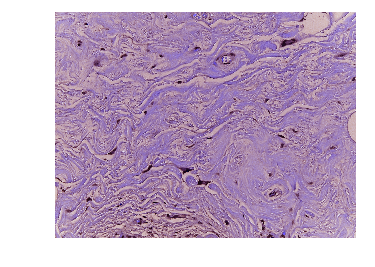

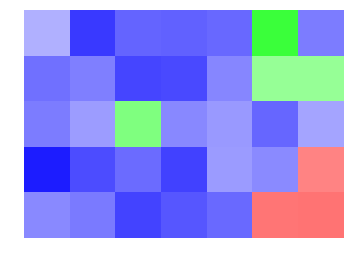

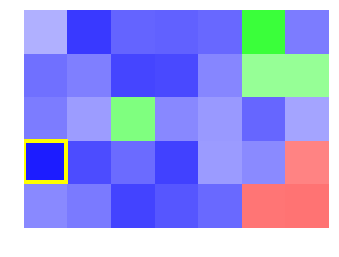

Benign 9
Benign
Benign


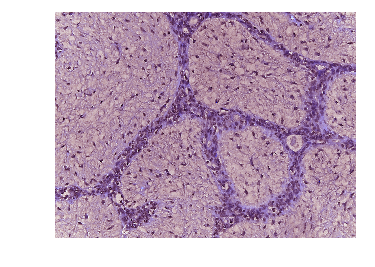

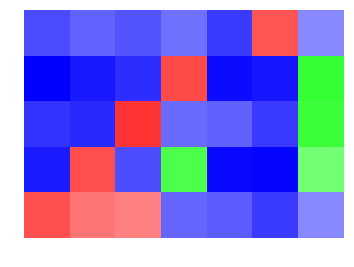

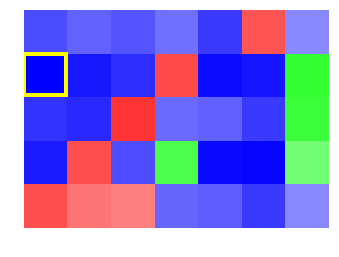

InSitu 10
InSitu
InSitu


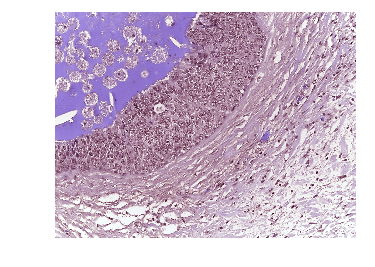

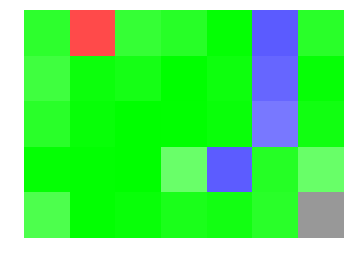

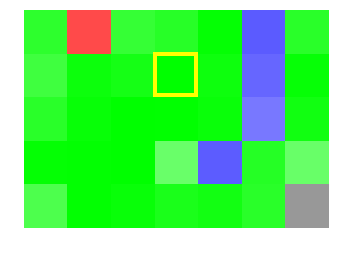

InSitu 12
InSitu
InSitu


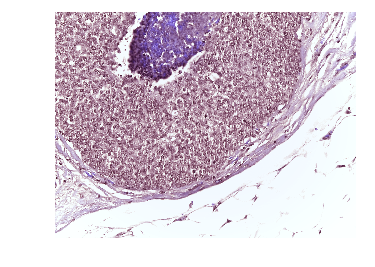

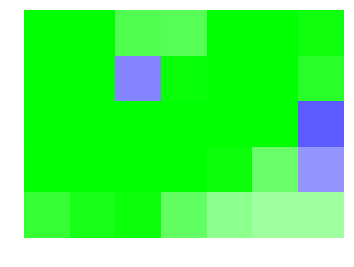

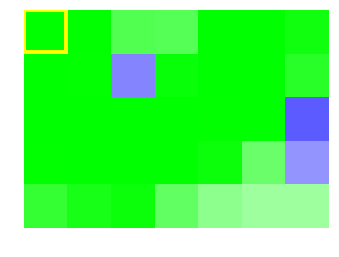

InSitu 13
InSitu
InSitu


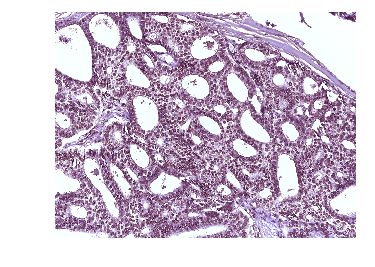

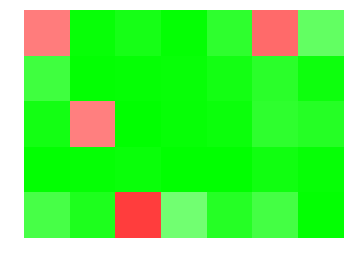

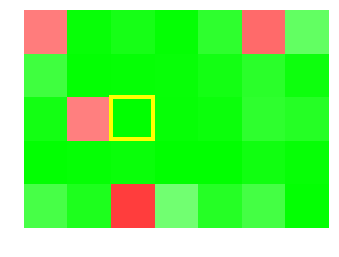

Invasive 15
Invasive
Invasive


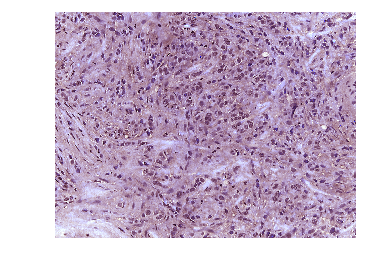

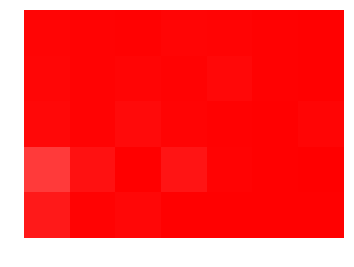

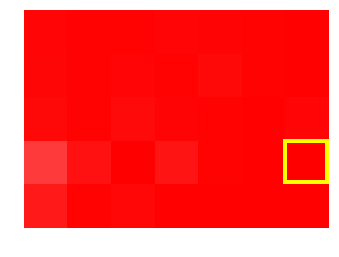

Invasive 17
Invasive
Invasive


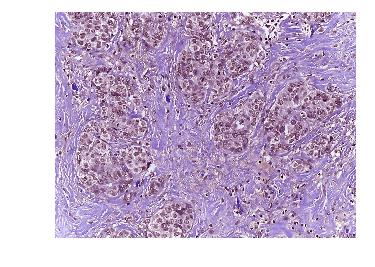

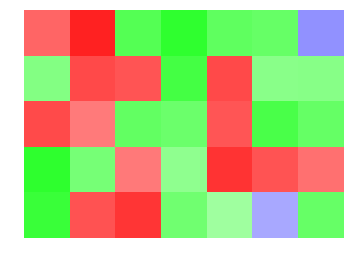

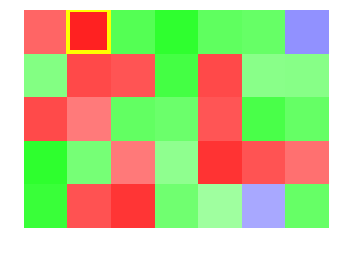

Invasive 18
Invasive
Invasive


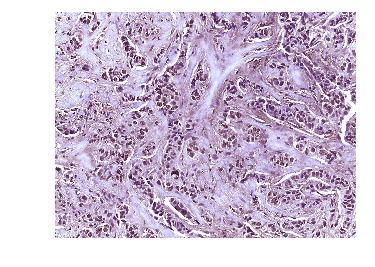

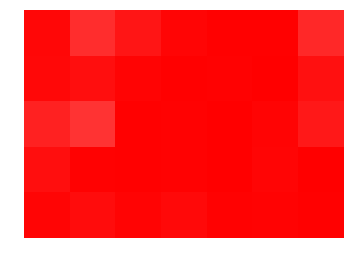

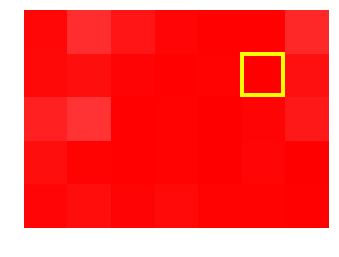

Invasive 19
Invasive
Invasive


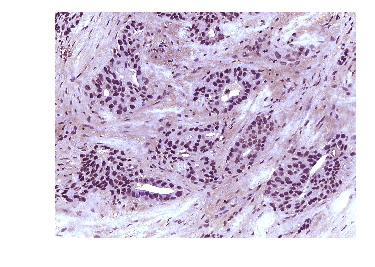

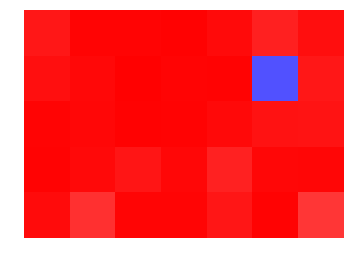

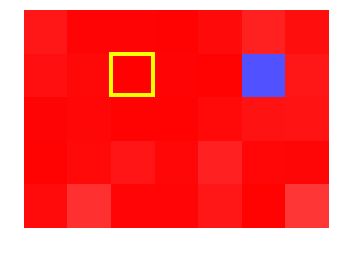

Normal 20
Normal
Normal


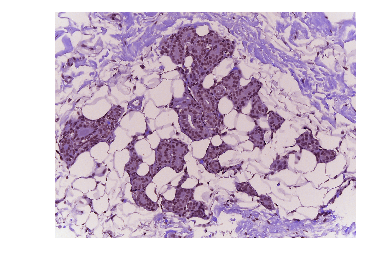

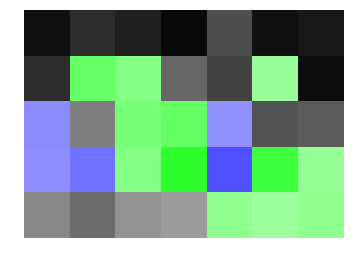

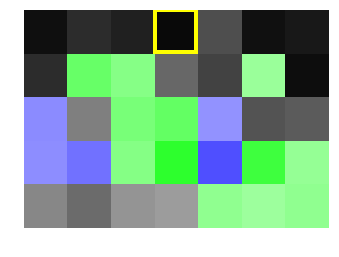

Normal 21
Normal
Normal


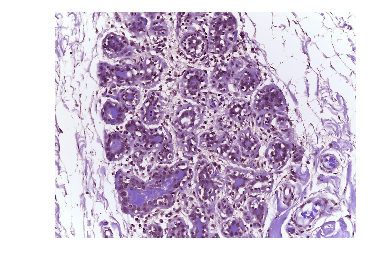

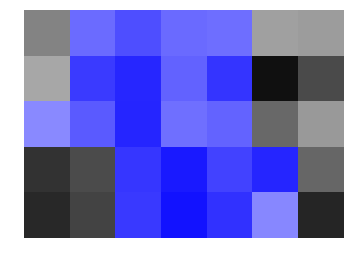

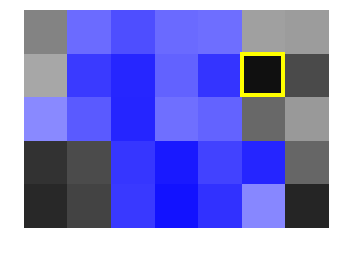

Normal 22
Normal
Normal


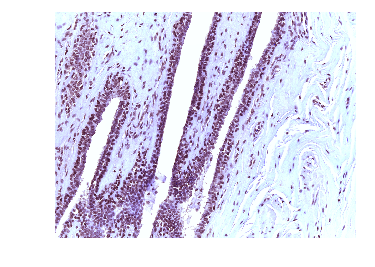

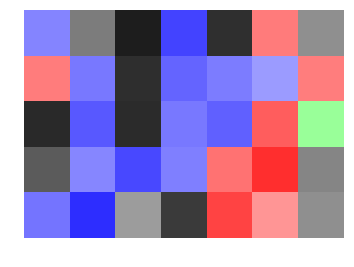

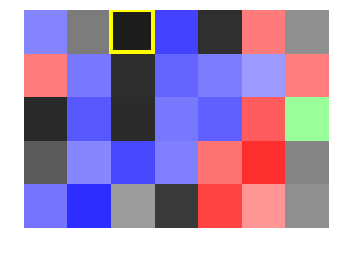

Normal 23
Normal
Normal


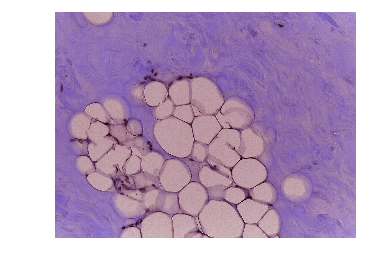

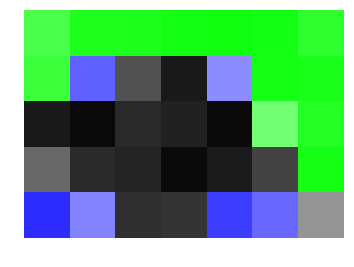

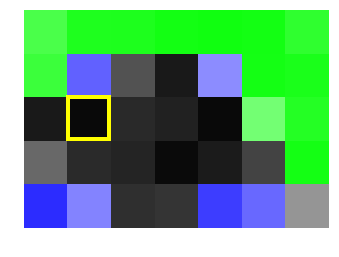

Benign 24
Benign
Benign


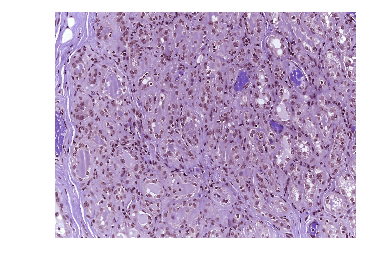

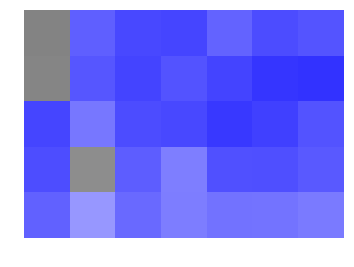

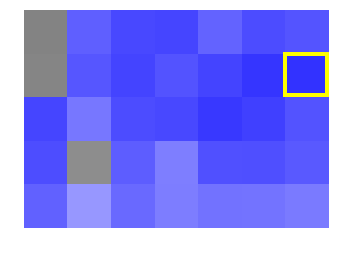

Benign 25
Benign
Benign


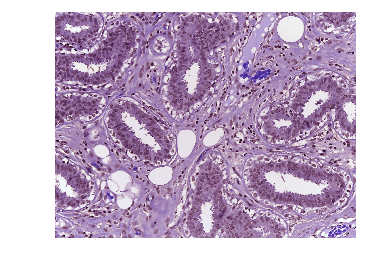

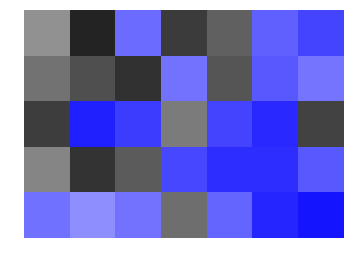

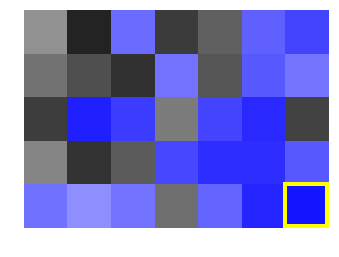

InSitu 28
InSitu
InSitu


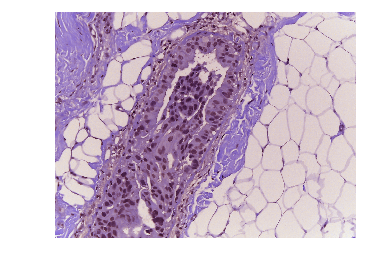

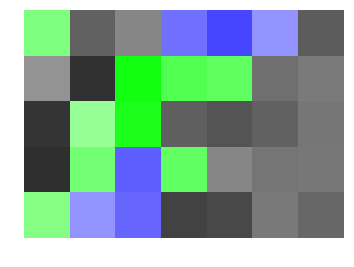

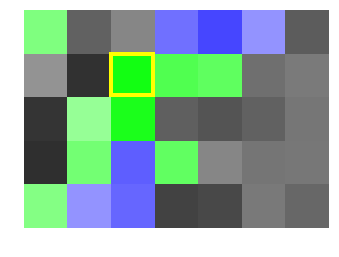

InSitu 30
InSitu
InSitu


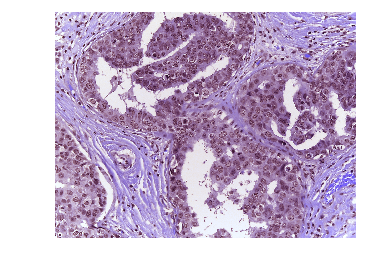

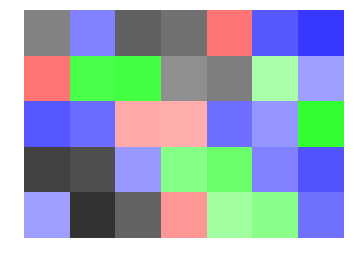

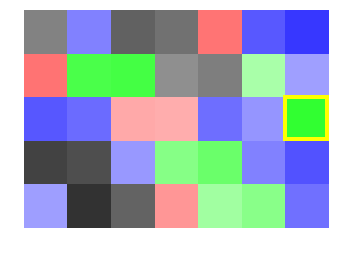

InSitu 31
InSitu
InSitu


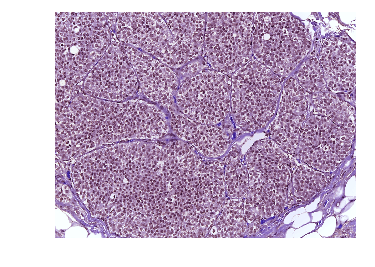

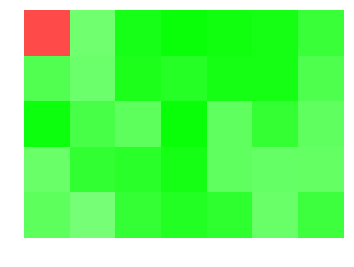

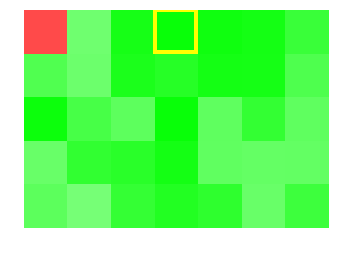

Invasive 33
Invasive
Invasive


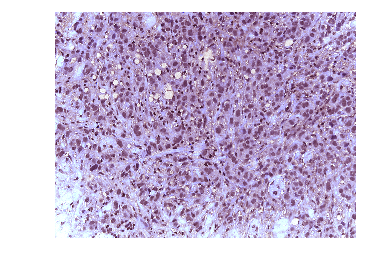

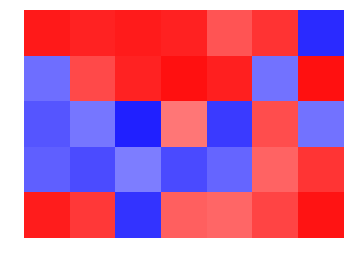

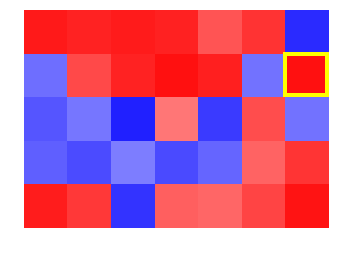

Invasive 34
Invasive
Invasive


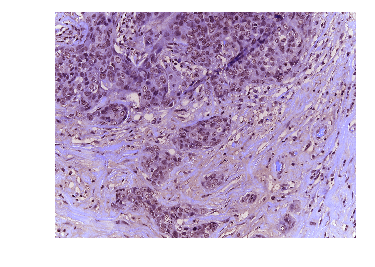

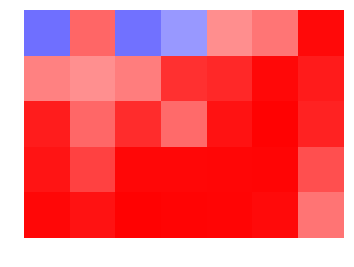

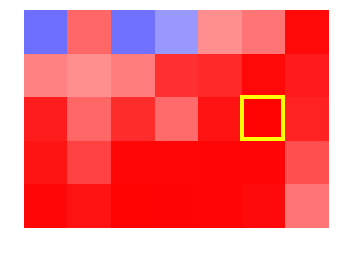

Invasive 35
Invasive
Invasive


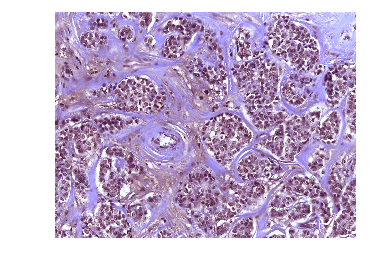

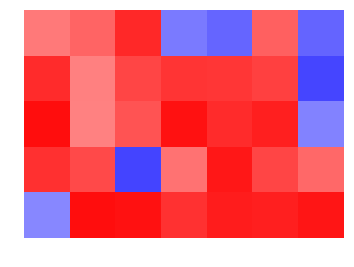

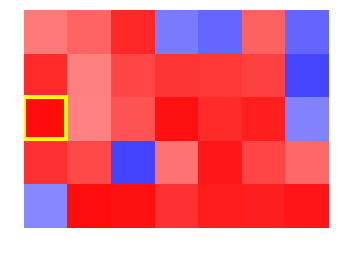

In [ ]:
# From gathered predicitons calculated metrics for various voting schemes and datasets

voting_schemes = ['majority', 'maxprobab', 'sumprobab', 'spatialconsist']

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib

def p_argmax(a): # Priority based arg max function, to handle draws in correct order
    m = np.max(a)

    if a[3] == m: # Invasive
        return 3
    if a[2] == m: # InSitu
        return 2
    if a[1] == m: # Benign
        return 1
    if a[0] == m: # Normal
        return 0

TEST_IMG_ID = 12

for TEST_IMG_ID in range(36):
#     P = np.reshape(PREDICTIONS[TEST_IMG_ID], (N_patches_y, N_patches_x, 4)) #### WRONG !!!
    P = np.reshape(PREDICTIONS[TEST_IMG_ID], (N_patches_x, N_patches_y, 4))
    P = np.transpose(P, axes=(1,0,2))
#     print PREDICTIONS[TEST_IMG_ID,:,0]
#     print P[:,:,0]
    TL = true_labels[TEST_IMG_ID]

#     if TEST_IMG_ID not in [1, 6,10,34]:
#         continue

    # Create B/W + R + G + B matrix showing probabilities
    PMAP = np.zeros( (N_patches_y, N_patches_x, 3) ) # RGB values

    AA = [] # probs
    BB = [] # labels
    for i in range(N_patches_y):
        for j in range(N_patches_x):

            mp = np.max(P[i,j])      # max prob for this patch
            label = p_argmax(P[i,j]) # label maximising the prob
            AA.append(mp)
            BB.append(label)

            if label == 0:                   # black/white scale
                PMAP[i,j,0] = 1.-mp
                PMAP[i,j,1] = 1.-mp
                PMAP[i,j,2] = 1.-mp
            elif label == 1:              # B
                PMAP[i,j,0] = 1.-mp
                PMAP[i,j,1] = 1.-mp
                PMAP[i,j,2] = 1.
            elif label == 2:              # G
                PMAP[i,j,0] = 1.-mp
                PMAP[i,j,1] = 1.
                PMAP[i,j,2] = 1.-mp
            elif label == 3:              # R
                PMAP[i,j,0] = 1.
                PMAP[i,j,1] = 1.-mp
                PMAP[i,j,2] = 1.-mp

    if classes[TL] != classes[ p_argmax( np.max(PREDICTIONS[TEST_IMG_ID], axis=0) ) ]:
        continue

    # PMAP[0,0] = [0.,0.,0.]
    print classes[TL], TEST_IMG_ID
    print classes[ p_argmax( np.max(PREDICTIONS[TEST_IMG_ID], axis=0) ) ]
    print classes[ BB[ np.argmax(AA) ] ]
    if classes[ p_argmax( np.max(PREDICTIONS[TEST_IMG_ID], axis=0) ) ] != classes[ BB[ np.argmax(AA) ] ]:
        raise ValueError("pruser!!!")

    plt.figure()
#     plt.figure(figsize=(14,8))
#     plt.subplot(1,2,1)
    plt.imshow(cv2.imread('./../Dataset/ICIAR2018_BACH_Challenge/Test_org_SN/'+str(TEST_IMG_ID)+'.tif'))
    plt.axis('off')
    plt.box
    plt.tight_layout()
    plt.show()
    plt.figure()
#     plt.figure(figsize=(12,12))

#     plt.subplot(1,2,2)
    plt.imshow(PMAP)
    plt.axis('off')
    # plt.colorbar(cmap=plt.cm.)
    # plt.colorbar()
    # plt.legend(['aaaaa'])
    # plt.tight_layout(pad=-.5)
    plt.tight_layout()
    plt.show()

#     print np.argmax(AA)
#     print np.argmax(AA) / N_patches_x
#     print np.argmax(AA) % N_patches_x
    XR = (np.argmax(AA) % N_patches_x) -0.5
    YR = (np.argmax(AA) / N_patches_x) -0.5
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111) # , aspect='equal'
    ax1.imshow(PMAP)
    ax1.add_patch(
    matplotlib.patches.Rectangle(
        (XR, YR),   # (x,y)
        .95,          # width
        .95,          # height
        linewidth=4,edgecolor='yellow',facecolor='none'
        )
    )
    plt.axis('off')
    plt.show()


#     break



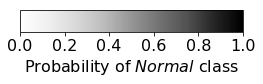

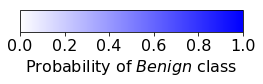

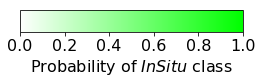

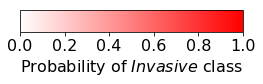

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 16})

XS = 4
YS = 0.4


fig, ax = plt.subplots(figsize=(XS, YS))


mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Greys, orientation = 'horizontal', label='Probability of $Normal$ class')
plt.show()


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(1.,1.,1.),(0.,0.,1.)])
fig, ax = plt.subplots(figsize=(XS, YS))
mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation = 'horizontal', label='Probability of $Benign$ class')
plt.show()

# fig, ax = plt.subplots(figsize=(XS, YS))
# mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Blues, orientation = 'horizontal', label='Probability of $Benign$ class')
# plt.show()


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(1.,1.,1.),(0.,1.,0.)])
fig, ax = plt.subplots(figsize=(XS, YS))
mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation = 'horizontal', label='Probability of $InSitu$ class')
plt.show()

# fig, ax = plt.subplots(figsize=(XS, YS))
# mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Greens, orientation = 'horizontal', label='Probability of $InSitu$ class')
# plt.show()


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(1.,1.,1.),(1.,0.,0.)])
fig, ax = plt.subplots(figsize=(XS, YS))
mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation = 'horizontal', label='Probability of $Invasive$ class')
plt.show()

# fig, ax = plt.subplots(figsize=(XS, YS))
# mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Reds, orientation = 'horizontal', label='Probability of $Invasive$ class')
# plt.show()
